In [ ]:
#  read csv /content/sample_data/texas_predict_unique_dates.csv to df

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, recall_score
import seaborn as sns


df = pd.read_csv('/content/sample_data/texas_predict_unique_dates.csv')
df

,Date,DSR,Spec_Humid,Mean_Temp,Max_Prec,Mean_Prec,Wind_Speed,y,Day,Month,Year,month_sin,month_cos
0,1990-01-01,2.9822,105.1395,16.6600,2.8993,6.0325,0.2787,0,1,1,1990,0.500000,0.866025
1,1990-01-02,4.9088,103.3510,24.9058,4.4692,7.9835,1.2124,0,2,1,1990,0.500000,0.866025
2,1990-01-03,5.6646,111.5488,33.1093,6.0139,11.2773,1.7705,0,3,1,1990,0.500000,0.866025
3,1990-01-04,2.9855,117.1203,21.2031,4.1647,8.9746,1.1339,0,4,1,1990,0.500000,0.866025
4,1990-01-05,2.4513,84.8636,28.7336,3.9949,7.5393,2.2638,0,5,1,1990,0.500000,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12838,2025-02-24,3.0070,204.5266,1.0000,4.0072,14.3659,0.0016,0,24,2,2025,0.866025,0.500000
12839,2025-02-25,3.1653,204.6302,0.8000,4.6684,17.0500,0.0016,0,25,2,2025,0.866025,0.500000
12840,2025-02-26,4.6489,199.1331,11.5000,5.6683,17.2181,0.0592,0,26,2,2025,0.866025,0.500000
12841,2025-02-27,4.1029,182.5379,1.4000,5.0074,12.6829,0.0035,0,27,2,2025,0.866025,0.500000


In [ ]:
# prompt: run Kolmogorov-Smirnov test for normality on all non date columns

from scipy import stats

# Select only numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns

# Perform KS test for normality on each numeric column
for col in numeric_cols:
  ks_statistic, p_value = stats.kstest(df[col], 'norm')
  print(f"Column: {col}, KS Statistic: {ks_statistic:.4f}, P-value: {p_value:.4f}")

  # Interpret the results (common alpha level is 0.05)
  if p_value < 0.05:
    print(f"  The column '{col}' does not appear to be normally distributed (reject null hypothesis).")
  else:
    print(f"  The column '{col}' appears to be normally distributed (fail to reject null hypothesis).")

Column: DSR, KS Statistic: 0.9824, P-value: 0.0000
  The column 'DSR' does not appear to be normally distributed (reject null hypothesis).
Column: Spec_Humid, KS Statistic: 0.9998, P-value: 0.0000
  The column 'Spec_Humid' does not appear to be normally distributed (reject null hypothesis).
Column: Mean_Temp, KS Statistic: 0.8395, P-value: 0.0000
  The column 'Mean_Temp' does not appear to be normally distributed (reject null hypothesis).
Column: Max_Prec, KS Statistic: 0.9691, P-value: 0.0000
  The column 'Max_Prec' does not appear to be normally distributed (reject null hypothesis).
Column: Mean_Prec, KS Statistic: 0.9716, P-value: 0.0000
  The column 'Mean_Prec' does not appear to be normally distributed (reject null hypothesis).
Column: Wind_Speed, KS Statistic: 0.5000, P-value: 0.0000
  The column 'Wind_Speed' does not appear to be normally distributed (reject null hypothesis).
Column: y, KS Statistic: 0.5000, P-value: 0.0000
  The column 'y' does not appear to be normally distrib

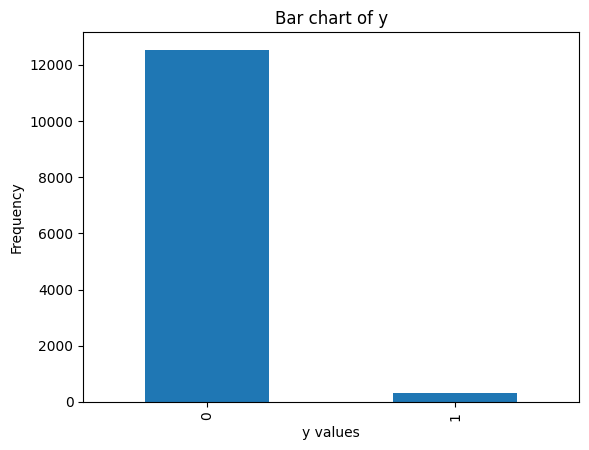

In [ ]:
#  bar chart of df['y']


df['y'].value_counts().plot(kind='bar')
plt.xlabel('y values')
plt.ylabel('Frequency')
plt.title('Bar chart of y')
plt.show()


In [ ]:
#  df.info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12843 entries, 0 to 12842
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        12843 non-null  object 
 1   DSR         12843 non-null  float64
 2   Spec_Humid  12843 non-null  float64
 3   Mean_Temp   12843 non-null  float64
 4   Max_Prec    12843 non-null  float64
 5   Mean_Prec   12843 non-null  float64
 6   Wind_Speed  12843 non-null  float64
 7   y           12843 non-null  int64  
 8   Day         12843 non-null  int64  
 9   Month       12843 non-null  int64  
 10  Year        12843 non-null  int64  
 11  month_sin   12843 non-null  float64
 12  month_cos   12843 non-null  float64
dtypes: float64(8), int64(4), object(1)
memory usage: 1.3+ MB


In [ ]:
df.describe()

,DSR,Spec_Humid,Mean_Temp,Max_Prec,Mean_Prec,Wind_Speed,y,Day,Month,Year,month_sin,month_cos
count,12843.000000,12843.000000,12843.000000,12843.000000,12843.000000,12843.000000,12843.000000,12843.000000,12843.00000,12843.000000,1.284300e+04,1.284300e+04
mean,4.230787,214.421368,37.290432,8.958056,18.717847,2.032208,0.023982,15.727867,6.49965,2007.083392,-1.650753e-03,1.170747e-03
std,1.088069,71.285395,46.185470,4.142042,8.116225,3.503859,0.152999,8.799582,3.45799,10.150118,7.057683e-01,7.084948e-01
min,1.732400,0.000000,0.000000,0.683700,-9.313700,0.000000,0.000000,1.000000,1.00000,1990.000000,-1.000000e+00,-1.000000e+00
25%,3.409750,147.525000,5.925250,5.281150,12.333500,0.046550,0.000000,8.000000,3.00000,1998.000000,-8.660254e-01,-8.660254e-01
50%,4.099200,216.811700,22.556600,8.573400,19.609700,0.539600,0.000000,16.000000,7.00000,2007.000000,-2.449294e-16,6.123234e-17
75%,4.901400,276.796450,52.115150,12.923700,26.094550,2.363600,0.000000,23.000000,10.00000,2016.000000,5.000000e-01,8.660254e-01
max,9.596600,346.648700,706.900000,17.703700,32.702700,36.097100,1.000000,31.000000,12.00000,2025.000000,1.000000e+00,1.000000e+00


In [ ]:
# prompt: drop the Mean_Temp column

df = df.drop('Mean_Temp', axis=1)
df.head()

,Date,DSR,Spec_Humid,Max_Prec,Mean_Prec,Wind_Speed,y,Day,Month,Year,month_sin,month_cos
0,1990-01-01,2.9822,105.1395,2.8993,6.0325,0.2787,0,1,1,1990,0.5,0.866025
1,1990-01-02,4.9088,103.3510,4.4692,7.9835,1.2124,0,2,1,1990,0.5,0.866025
2,1990-01-03,5.6646,111.5488,6.0139,11.2773,1.7705,0,3,1,1990,0.5,0.866025
3,1990-01-04,2.9855,117.1203,4.1647,8.9746,1.1339,0,4,1,1990,0.5,0.866025
4,1990-01-05,2.4513,84.8636,3.9949,7.5393,2.2638,0,5,1,1990,0.5,0.866025


In [ ]:

sum(df['y'])

308

In [ ]:
#  pivot table of df by year with colums vallue y and sum aggregation

# Create a temporary column of ones to use for counting
df['count'] = 1

# Create the pivot table, counting occurrences of 'y' values per year
pivot_df = df.pivot_table(index='Year', columns='y', values='count', aggfunc='sum')

# Remove the temporary count column
df = df.drop('count', axis=1)

pivot_df

y,0,1
Year,,
1990,365.0,NaN
1991,365.0,NaN
1992,366.0,NaN
1993,365.0,NaN
1994,365.0,NaN
1995,365.0,NaN
1996,356.0,10.0
1997,353.0,12.0
1998,354.0,11.0


In [ ]:
#  in df  keep values of 2000-2024


# Convert the 'year' column to numeric, coercing errors to NaN
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

# Drop rows where 'year' is NaN (if any resulted from conversion)
df.dropna(subset=['Year'], inplace=True)

# Filter the DataFrame to keep rows where 'year' is between 2000 and 2024 (inclusive)
df = df[(df['Year'] >= 2000) & (df['Year'] <= 2024)]

# Display the filtered DataFrame
df

,Date,DSR,Spec_Humid,Max_Prec,Mean_Prec,Wind_Speed,y,Day,Month,Year,month_sin,month_cos
3652,2000-01-01,4.9708,129.8838,5.4656,14.4458,0.0269,0,1,1,2000,5.000000e-01,0.866025
3653,2000-01-02,4.8003,127.9465,6.5890,15.8610,0.2360,0,2,1,2000,5.000000e-01,0.866025
3654,2000-01-03,6.8073,130.7054,4.0460,10.5353,0.4479,0,3,1,2000,5.000000e-01,0.866025
3655,2000-01-04,4.4992,140.5638,1.8326,4.0305,0.0004,0,4,1,2000,5.000000e-01,0.866025
3656,2000-01-05,4.3340,137.8425,2.1662,5.0075,0.0000,0,5,1,2000,5.000000e-01,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...
12779,2024-12-27,3.5574,137.9629,5.2995,15.2528,0.3349,0,27,12,2024,-2.449294e-16,1.000000
12780,2024-12-28,3.9390,123.8587,5.7964,14.4198,6.5919,0,28,12,2024,-2.449294e-16,1.000000
12781,2024-12-29,2.8622,139.9678,4.4680,14.9522,0.0021,0,29,12,2024,-2.449294e-16,1.000000
12782,2024-12-30,4.6419,143.4807,4.4163,15.9207,0.0007,0,30,12,2024,-2.449294e-16,1.000000


In [ ]:
#  convert day to 1-365

import pandas as pd
df['Date'] = pd.to_datetime(df['Date'])
df['DayOfYear'] = df['Date'].dt.dayofyear


In [ ]:
# prompt: drop  all months columns and day , but keep dayofyear

# Get the list of month columns (assuming they are named 'Month_1', 'Month_2', ..., 'Month_12' or similar)
# Check for columns that start with 'month' in a case-insensitive manner
month_cols = [col for col in df.columns if col.lower().startswith('month')]

# Drop the month columns, the 'Day' column, and the original 'Date' column
cols_to_drop = month_cols + ['Day']
df = df.drop(columns=cols_to_drop, errors='ignore')

df

,Date,DSR,Spec_Humid,Max_Prec,Mean_Prec,Wind_Speed,y,Year,DayOfYear
3652,2000-01-01,4.9708,129.8838,5.4656,14.4458,0.0269,0,2000,1
3653,2000-01-02,4.8003,127.9465,6.5890,15.8610,0.2360,0,2000,2
3654,2000-01-03,6.8073,130.7054,4.0460,10.5353,0.4479,0,2000,3
3655,2000-01-04,4.4992,140.5638,1.8326,4.0305,0.0004,0,2000,4
3656,2000-01-05,4.3340,137.8425,2.1662,5.0075,0.0000,0,2000,5
...,...,...,...,...,...,...,...,...,...
12779,2024-12-27,3.5574,137.9629,5.2995,15.2528,0.3349,0,2024,362
12780,2024-12-28,3.9390,123.8587,5.7964,14.4198,6.5919,0,2024,363
12781,2024-12-29,2.8622,139.9678,4.4680,14.9522,0.0021,0,2024,364
12782,2024-12-30,4.6419,143.4807,4.4163,15.9207,0.0007,0,2024,365


In [ ]:
# prompt: convert dayofyear to cyclic

import numpy as np

def cyclic_transform(df, col, max_val):
  """
  Applies cyclic transformation to a specified column in a DataFrame.

  Args:
    df: The input Pandas DataFrame.
    col: The name of the column to transform.
    max_val: The maximum possible value for the column (e.g., 365 for DayOfYear).

  Returns:
    The DataFrame with two new columns representing the cyclic transformation
    of the specified column (col_sin and col_cos).
  """
  df[col + '_sin'] = np.sin(2 * np.pi * df[col] / max_val)
  df[col + '_cos'] = np.cos(2 * np.pi * df[col] / max_val)
  return df

df = cyclic_transform(df, 'DayOfYear', 365)
df

,Date,DSR,Spec_Humid,Max_Prec,Mean_Prec,Wind_Speed,y,Year,DayOfYear,DayOfYear_sin,DayOfYear_cos
3652,2000-01-01,4.9708,129.8838,5.4656,14.4458,0.0269,0,2000,1,1.721336e-02,0.999852
3653,2000-01-02,4.8003,127.9465,6.5890,15.8610,0.2360,0,2000,2,3.442161e-02,0.999407
3654,2000-01-03,6.8073,130.7054,4.0460,10.5353,0.4479,0,2000,3,5.161967e-02,0.998667
3655,2000-01-04,4.4992,140.5638,1.8326,4.0305,0.0004,0,2000,4,6.880243e-02,0.997630
3656,2000-01-05,4.3340,137.8425,2.1662,5.0075,0.0000,0,2000,5,8.596480e-02,0.996298
...,...,...,...,...,...,...,...,...,...,...,...
12779,2024-12-27,3.5574,137.9629,5.2995,15.2528,0.3349,0,2024,362,-5.161967e-02,0.998667
12780,2024-12-28,3.9390,123.8587,5.7964,14.4198,6.5919,0,2024,363,-3.442161e-02,0.999407
12781,2024-12-29,2.8622,139.9678,4.4680,14.9522,0.0021,0,2024,364,-1.721336e-02,0.999852
12782,2024-12-30,4.6419,143.4807,4.4163,15.9207,0.0007,0,2024,365,6.432491e-16,1.000000


In [ ]:
#  drop dayofyear

df = df.drop('DayOfYear', axis=1)
df

,Date,DSR,Spec_Humid,Max_Prec,Mean_Prec,Wind_Speed,y,Year,DayOfYear_sin,DayOfYear_cos
3652,2000-01-01,4.9708,129.8838,5.4656,14.4458,0.0269,0,2000,1.721336e-02,0.999852
3653,2000-01-02,4.8003,127.9465,6.5890,15.8610,0.2360,0,2000,3.442161e-02,0.999407
3654,2000-01-03,6.8073,130.7054,4.0460,10.5353,0.4479,0,2000,5.161967e-02,0.998667
3655,2000-01-04,4.4992,140.5638,1.8326,4.0305,0.0004,0,2000,6.880243e-02,0.997630
3656,2000-01-05,4.3340,137.8425,2.1662,5.0075,0.0000,0,2000,8.596480e-02,0.996298
...,...,...,...,...,...,...,...,...,...,...
12779,2024-12-27,3.5574,137.9629,5.2995,15.2528,0.3349,0,2024,-5.161967e-02,0.998667
12780,2024-12-28,3.9390,123.8587,5.7964,14.4198,6.5919,0,2024,-3.442161e-02,0.999407
12781,2024-12-29,2.8622,139.9678,4.4680,14.9522,0.0021,0,2024,-1.721336e-02,0.999852
12782,2024-12-30,4.6419,143.4807,4.4163,15.9207,0.0007,0,2024,6.432491e-16,1.000000


In [ ]:
# prompt: standardize all fetures except date, year and y

from sklearn.preprocessing import StandardScaler

# Select columns to standardize (all except 'Date', and 'y')
cols_to_standardize = [col for col in df.columns if col not in ['Date', 'y']]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the selected columns
df[cols_to_standardize] = scaler.fit_transform(df[cols_to_standardize])

df


,Date,DSR,Spec_Humid,Max_Prec,Mean_Prec,Wind_Speed,y,Year,DayOfYear_sin,DayOfYear_cos
3652,2000-01-01,0.632512,-1.206320,-0.842061,-0.543678,-0.559127,0,-1.663953,0.024334,1.412380
3653,2000-01-02,0.476858,-1.233360,-0.569974,-0.370314,-0.500460,0,-1.663953,0.048679,1.411752
3654,2000-01-03,2.309095,-1.194853,-1.185888,-1.022721,-0.441008,0,-1.663953,0.073011,1.410705
3655,2000-01-04,0.201977,-1.057255,-1.721973,-1.819570,-0.566562,0,-1.663953,0.097320,1.409240
3656,2000-01-05,0.051162,-1.095238,-1.641175,-1.699886,-0.566674,0,-1.663953,0.121601,1.407356
...,...,...,...,...,...,...,...,...,...,...
12779,2024-12-27,-0.657813,-1.093557,-0.882291,-0.444820,-0.472712,0,1.663953,-0.073048,1.410705
12780,2024-12-28,-0.309442,-1.290415,-0.761942,-0.546863,1.282796,0,1.663953,-0.048717,1.411752
12781,2024-12-29,-1.292477,-1.065574,-1.083680,-0.481644,-0.566085,0,1.663953,-0.024371,1.412380
12782,2024-12-30,0.332251,-1.016543,-1.096201,-0.363001,-0.566478,0,1.663953,-0.000019,1.412590


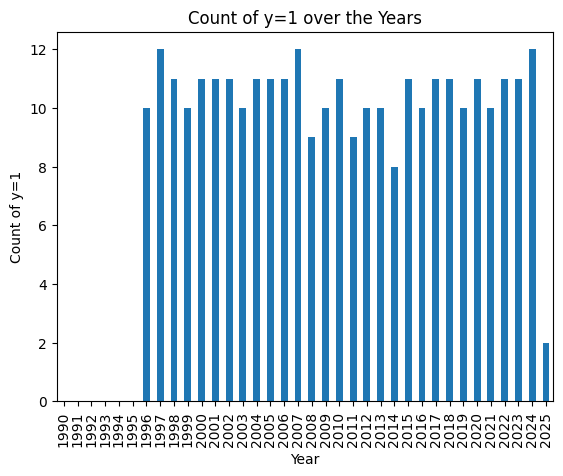

In [ ]:
#  histogram of pivot_table{1] over years

# Check if pivot_df has the column for y=1
if 1 in pivot_df.columns:
  # Plot the histogram for the column corresponding to y=1 over the years
  pivot_df[1].plot(kind='bar')
  plt.xlabel('Year')
  plt.ylabel('Count of y=1')
  plt.title('Count of y=1 over the Years')
  plt.show()
else:
  print("Column '1' (corresponding to y=1) does not exist in the pivot table.")

In [ ]:
# : test train split with y as the target

# Drop the original 'Date' column if it still exists and is not needed for features
if 'Date' in df.columns:
    df = df.drop('Date', axis=1)


# Define features (X) and target (y)
X = df.drop('y', axis=1)
y = df['y']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (7305, 8)
Shape of X_test: (1827, 8)
Shape of y_train: (7305,)
Shape of y_test: (1827,)



📌 Training Decision Tree with SMOTE...

🔍 Accuracy for Decision Tree: 0.9453
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1774
           1       0.30      0.68      0.42        53

    accuracy                           0.95      1827
   macro avg       0.65      0.82      0.69      1827
weighted avg       0.97      0.95      0.96      1827



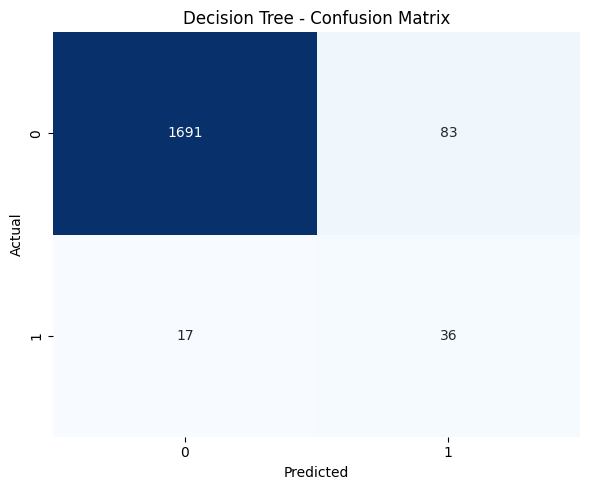

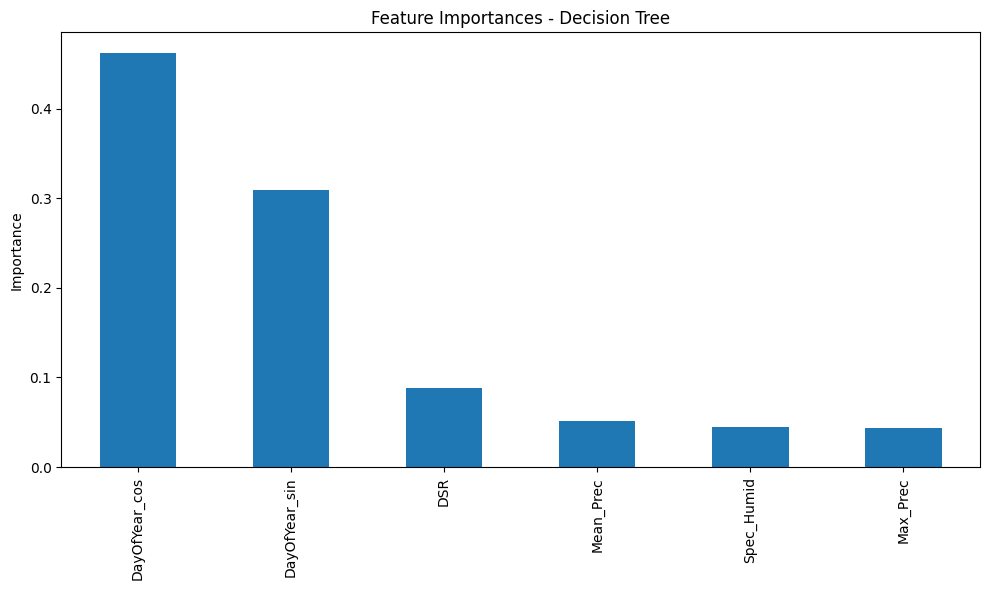


📌 Training Random Forest with SMOTE...

🔍 Accuracy for Random Forest: 0.9715
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1774
           1       0.51      0.62      0.56        53

    accuracy                           0.97      1827
   macro avg       0.75      0.80      0.77      1827
weighted avg       0.97      0.97      0.97      1827



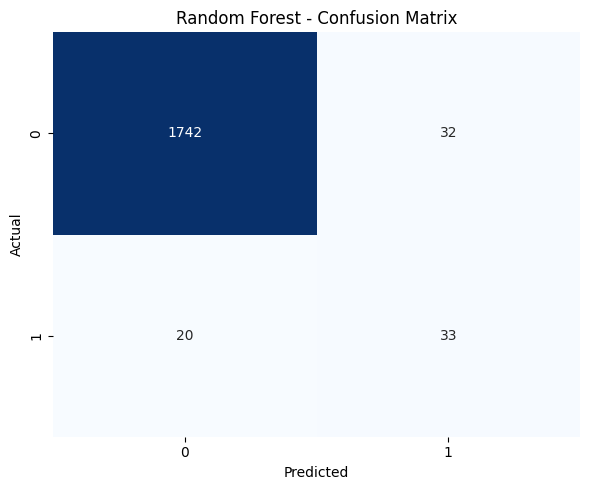

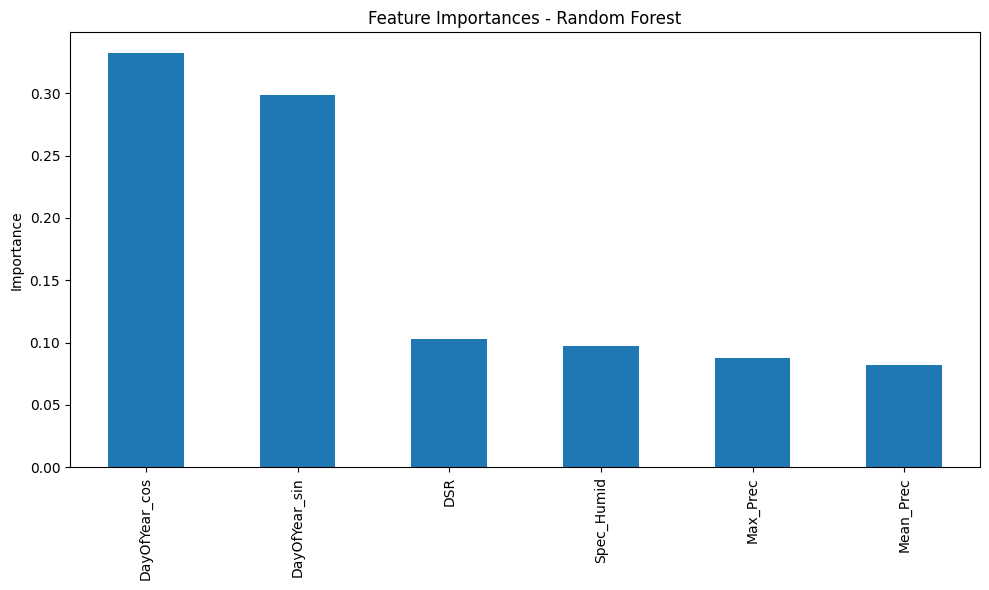


📌 Training Logistic Regression with SMOTE...

🔍 Accuracy for Logistic Regression: 0.4888
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.49      0.65      1774
           1       0.03      0.49      0.05        53

    accuracy                           0.49      1827
   macro avg       0.50      0.49      0.35      1827
weighted avg       0.94      0.49      0.63      1827



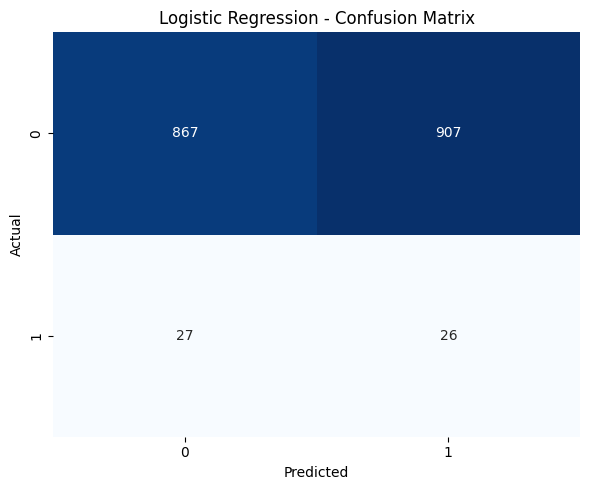


📌 Training SVM with SMOTE...

🔍 Accuracy for SVM: 0.5320
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.53      0.69      1774
           1       0.03      0.45      0.05        53

    accuracy                           0.53      1827
   macro avg       0.50      0.49      0.37      1827
weighted avg       0.94      0.53      0.67      1827



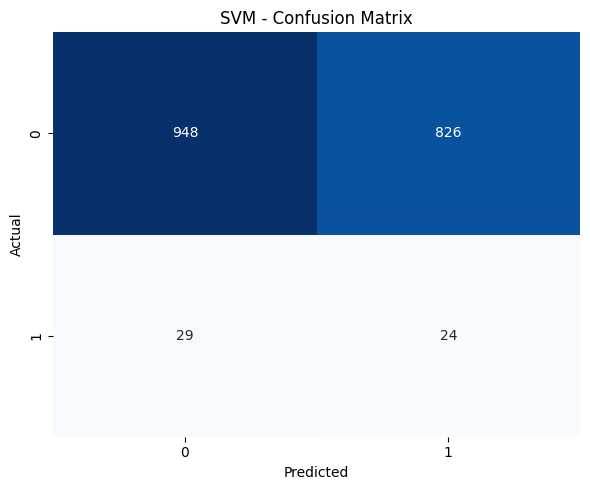


📌 Training XGBoost with SMOTE...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔍 Accuracy for XGBoost: 0.9190
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      1774
           1       0.25      0.87      0.38        53

    accuracy                           0.92      1827
   macro avg       0.62      0.89      0.67      1827
weighted avg       0.97      0.92      0.94      1827



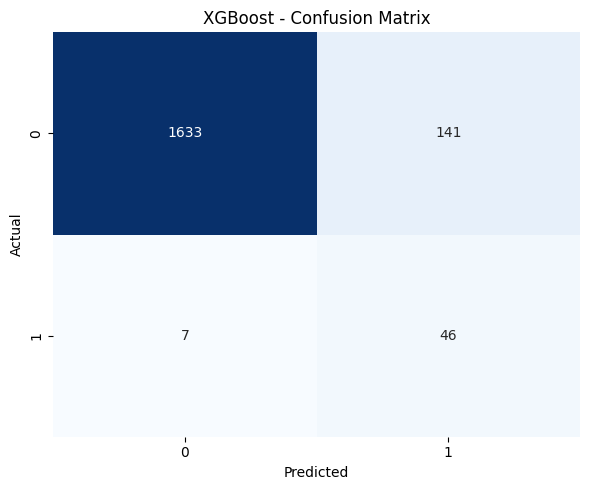

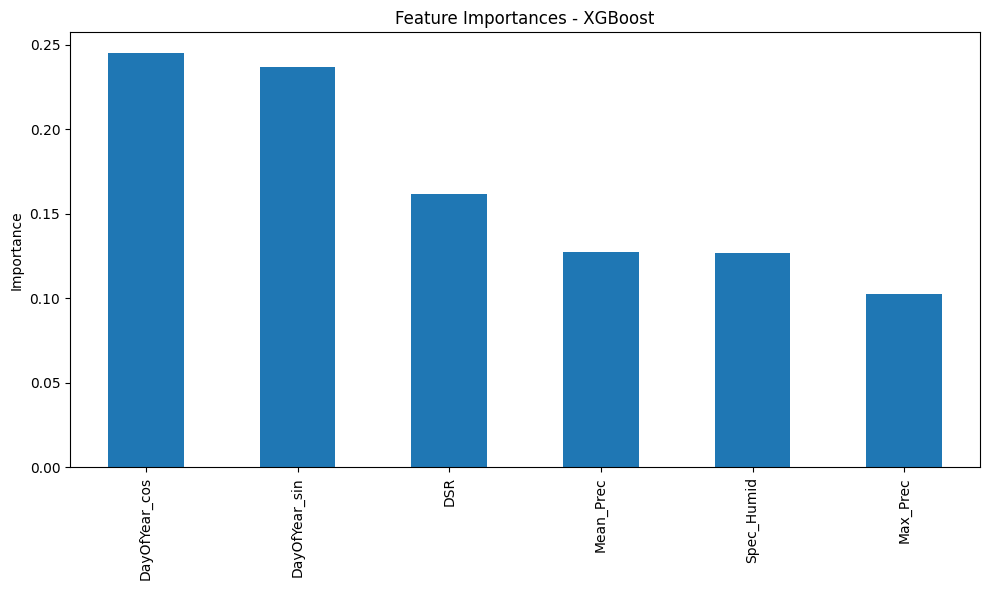

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Drop specified columns
cols_to_drop = ['max_prec', 'Year', 'Wind_Speed']
X_train_reduced = X_train.drop(columns=cols_to_drop, errors='ignore')
X_test_reduced = X_test.drop(columns=cols_to_drop, errors='ignore')

# Apply SMOTE to balance the training data
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train_reduced, y_train)

# Scale data for SVM and Logistic Regression
scaler = StandardScaler()
X_train_bal_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test_reduced)

# Models to train
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
                              use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

scaled_models = ["Logistic Regression", "SVM"]

# Train, predict, and evaluate
for name, model in models.items():
    print(f"\n📌 Training {name} with SMOTE...")

    if name in scaled_models:
        model.fit(X_train_bal_scaled, y_train_bal)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train_bal, y_train_bal)
        y_pred = model.predict(X_test_reduced)

    # Accuracy and classification report
    acc = accuracy_score(y_test, y_pred)
    print(f"\n🔍 Accuracy for {name}: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # Feature importance (if available)
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        importance_series = pd.Series(importances, index=X_train_reduced.columns).sort_values(ascending=False)
        plt.figure(figsize=(10, 6))
        importance_series.plot(kind='bar')
        plt.title(f'Feature Importances - {name}')
        plt.ylabel('Importance')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 15.0 MB/s eta 0:00:00


[I 2025-06-28 11:33:51,968] A new study created in memory with name: no-name-3317407e-6af3-48b3-ab30-8ff68bef7768
[I 2025-06-28 11:33:52,128] Trial 0 finished with value: 0.4372093023255814 and parameters: {'criterion': 'gini', 'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.4372093023255814.


Optimizing Decision Tree...


[I 2025-06-28 11:33:52,323] Trial 1 finished with value: 0.4433497536945813 and parameters: {'criterion': 'entropy', 'max_depth': 41, 'min_samples_split': 7, 'min_samples_leaf': 19}. Best is trial 1 with value: 0.4433497536945813.
[I 2025-06-28 11:33:52,524] Trial 2 finished with value: 0.4318181818181818 and parameters: {'criterion': 'entropy', 'max_depth': 40, 'min_samples_split': 17, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.4433497536945813.
[I 2025-06-28 11:33:52,608] Trial 3 finished with value: 0.38 and parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 14}. Best is trial 1 with value: 0.4433497536945813.
[I 2025-06-28 11:33:52,632] Trial 4 finished with value: 0.11940298507462686 and parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 6, 'min_samples_leaf': 18}. Best is trial 1 with value: 0.4433497536945813.
[I 2025-06-28 11:33:52,754] Trial 5 finished with value: 0.4778761061946903 and parameters: {'cri

Optimizing Random Forest...


[I 2025-06-28 11:34:06,042] Trial 0 finished with value: 0.5882352941176471 and parameters: {'n_estimators': 64, 'max_depth': 49, 'min_samples_split': 5, 'min_samples_leaf': 4, 'criterion': 'entropy'}. Best is trial 0 with value: 0.5882352941176471.
[I 2025-06-28 11:34:21,173] Trial 1 finished with value: 0.5276073619631901 and parameters: {'n_estimators': 364, 'max_depth': 36, 'min_samples_split': 10, 'min_samples_leaf': 19, 'criterion': 'entropy'}. Best is trial 0 with value: 0.5882352941176471.
[I 2025-06-28 11:34:31,545] Trial 2 finished with value: 0.5714285714285714 and parameters: {'n_estimators': 322, 'max_depth': 33, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'gini'}. Best is trial 0 with value: 0.5882352941176471.
[I 2025-06-28 11:34:35,538] Trial 3 finished with value: 0.5283018867924528 and parameters: {'n_estimators': 81, 'max_depth': 26, 'min_samples_split': 16, 'min_samples_leaf': 17, 'criterion': 'entropy'}. Best is trial 0 with value: 0.588235294117647

Optimizing XGBoost...


[I 2025-06-28 11:39:55,618] Trial 1 finished with value: 0.5341614906832298 and parameters: {'eta': 0.12291660914397234, 'max_depth': 8, 'subsample': 0.8069234050368057, 'colsample_bytree': 0.8870941411810305, 'min_child_weight': 5, 'gamma': 0.4984687288962803, 'lambda': 1.889312740931022, 'alpha': 1.1076672344873004}. Best is trial 1 with value: 0.5341614906832298.
[I 2025-06-28 11:39:55,836] Trial 2 finished with value: 0.4883720930232558 and parameters: {'eta': 0.17780774897255647, 'max_depth': 5, 'subsample': 0.6544649093643429, 'colsample_bytree': 0.8660654124033186, 'min_child_weight': 4, 'gamma': 0.47687418936048226, 'lambda': 1.4298702970061352, 'alpha': 1.0202402838452338}. Best is trial 1 with value: 0.5341614906832298.
[I 2025-06-28 11:39:55,958] Trial 3 finished with value: 0.4155844155844156 and parameters: {'eta': 0.09233843206548198, 'max_depth': 3, 'subsample': 0.6999843369569676, 'colsample_bytree': 0.6719202338466065, 'min_child_weight': 4, 'gamma': 0.2212183677911287


Best Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 7}

Decision Tree - Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1774
           1       0.42      0.70      0.52        53

    accuracy                           0.96      1827
   macro avg       0.71      0.83      0.75      1827
weighted avg       0.97      0.96      0.97      1827



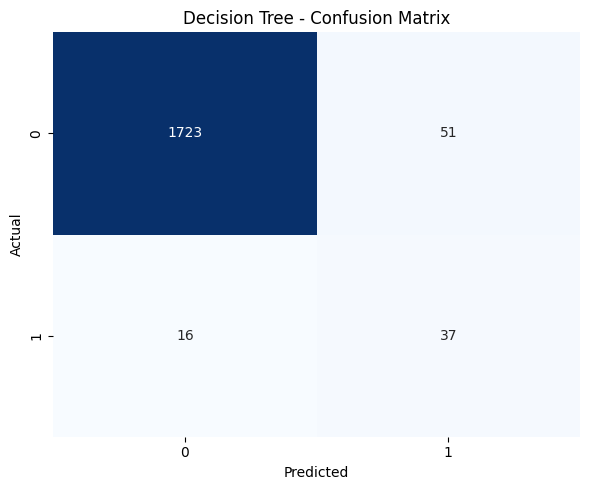

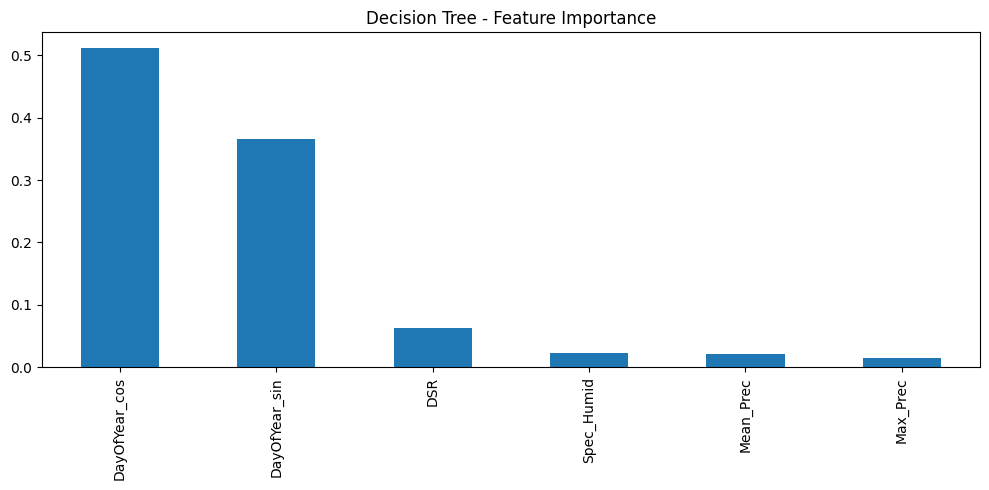


Best Random Forest Parameters: {'n_estimators': 146, 'max_depth': 42, 'min_samples_split': 6, 'min_samples_leaf': 4, 'criterion': 'entropy'}

Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1774
           1       0.52      0.75      0.62        53

    accuracy                           0.97      1827
   macro avg       0.76      0.87      0.80      1827
weighted avg       0.98      0.97      0.98      1827



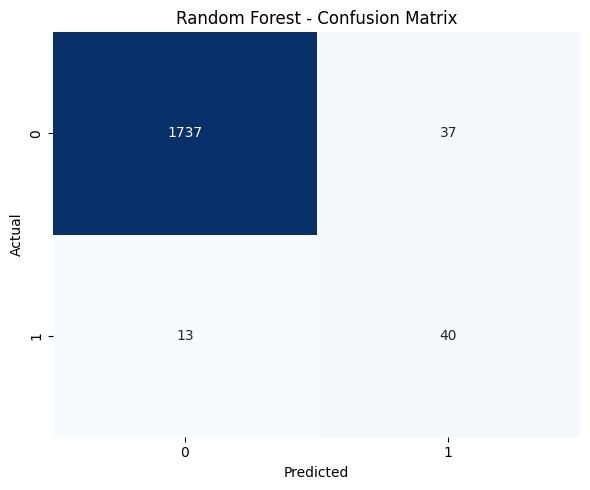

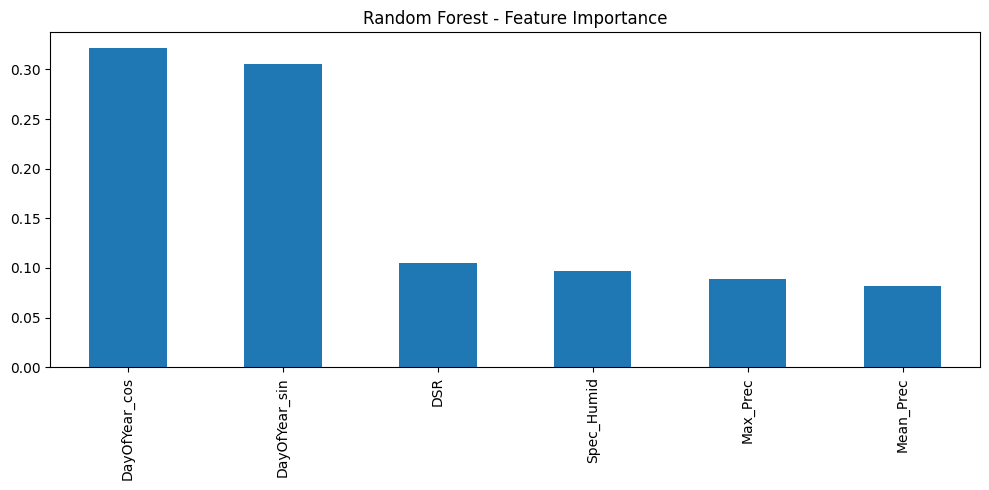


Best XGBoost Parameters: {'eta': 0.12447964916384999, 'max_depth': 9, 'subsample': 0.9525174411271301, 'colsample_bytree': 0.7742396973212919, 'min_child_weight': 6, 'gamma': 0.28083592614047387, 'lambda': 0.6526022967579375, 'alpha': 1.817342427655461}

XGBoost - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1774
           1       0.44      0.85      0.58        53

    accuracy                           0.96      1827
   macro avg       0.72      0.91      0.78      1827
weighted avg       0.98      0.96      0.97      1827



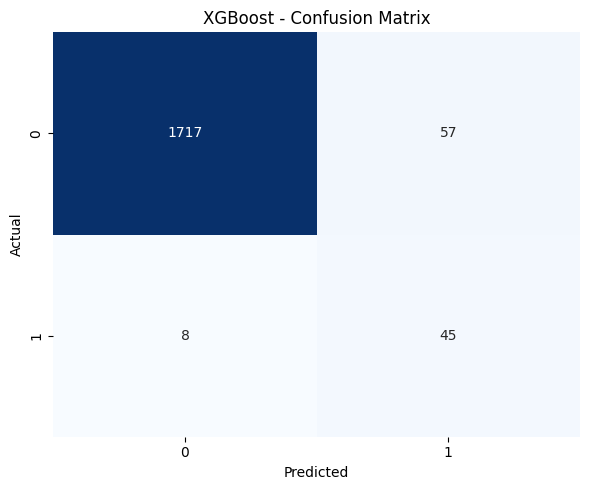

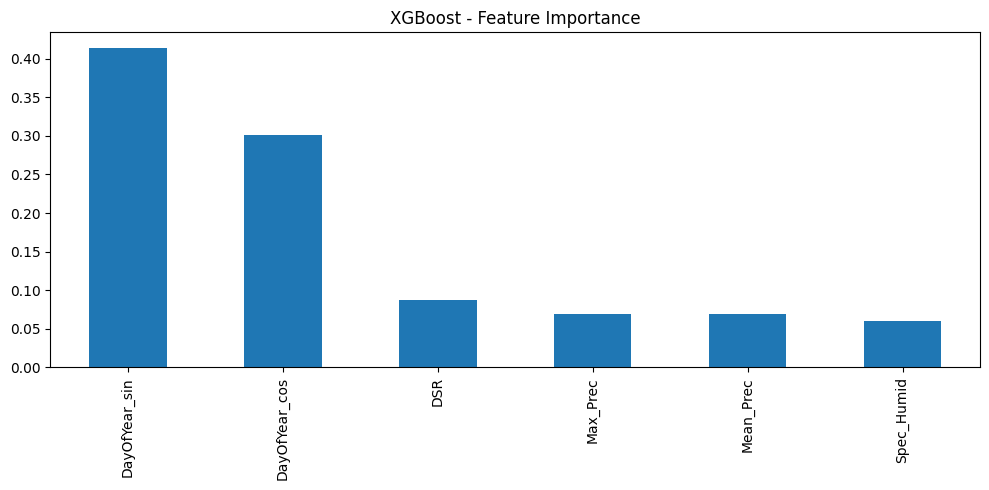

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install optuna
import optuna
import warnings

from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')

# Drop specified columns
cols_to_drop = ['Max_Prec', 'Year', 'Wind_Speed'] # Corrected 'max_prec' to 'Max_Prec'
X_train_reduced = X_train.drop(columns=cols_to_drop, errors='ignore')
X_test_reduced = X_test.drop(columns=cols_to_drop, errors='ignore')

# Apply SMOTE to balance the training data
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train_reduced, y_train)


# ------------------------------
# Objective functions
# ------------------------------

def objective_dt(trial):
    model = DecisionTreeClassifier(
        criterion=trial.suggest_categorical("criterion", ["gini", "entropy"]),
        max_depth=trial.suggest_int("max_depth", 1, 50),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 20),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 20),
        random_state=42
    )
    model.fit(X_train_bal, y_train_bal)
    preds = model.predict(X_test_reduced)
    return f1_score(y_test, preds)

def objective_rf(trial):
    model = RandomForestClassifier(
        n_estimators=trial.suggest_int("n_estimators", 50, 500),
        max_depth=trial.suggest_int("max_depth", 1, 50),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 20),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 20),
        criterion=trial.suggest_categorical("criterion", ["gini", "entropy"]),
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train_bal, y_train_bal)
    preds = model.predict(X_test_reduced)
    return f1_score(y_test, preds)

def objective_xgb(trial):
    param = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "eta": trial.suggest_float("eta", 0.005, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0, 0.5),
        "lambda": trial.suggest_float("lambda", 0.5, 2),
        "alpha": trial.suggest_float("alpha", 0.5, 2),
        "scale_pos_weight": (y_train_bal == 0).sum() / (y_train_bal == 1).sum(),
        "seed": 42
    }
    model = XGBClassifier(**param, use_label_encoder=False)
    model.fit(X_train_bal, y_train_bal)
    preds = model.predict(X_test_reduced)
    return f1_score(y_test, preds)

# ------------------------------
# Run studies
# ------------------------------

print("Optimizing Decision Tree...")
study_dt = optuna.create_study(direction="maximize")
study_dt.optimize(objective_dt, n_trials=50)

print("Optimizing Random Forest...")
study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective_rf, n_trials=50)

print("Optimizing XGBoost...")
study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgb, n_trials=50)

# ------------------------------
# Helper: Evaluate best model
# ------------------------------

def evaluate_best_model(model, name):
    y_pred_best = model.predict(X_test_reduced)
    print(f"\n{name} - Classification Report:")
    print(classification_report(y_test, y_pred_best, zero_division=0))

    cm = confusion_matrix(y_test, y_pred_best)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        pd.Series(importances, index=X_train_reduced.columns).sort_values(ascending=False).plot(kind='bar', figsize=(10, 5))
        plt.title(f'{name} - Feature Importance')
        plt.tight_layout()
        plt.show()

# ------------------------------
# Train and evaluate best models
# ------------------------------

# Decision Tree
print("\nBest Decision Tree Parameters:", study_dt.best_params)
dt_model = DecisionTreeClassifier(**study_dt.best_params, random_state=42)
dt_model.fit(X_train_bal, y_train_bal)
evaluate_best_model(dt_model, "Decision Tree")

# Random Forest
print("\nBest Random Forest Parameters:", study_rf.best_params)
rf_model = RandomForestClassifier(**study_rf.best_params, random_state=42, n_jobs=-1)
rf_model.fit(X_train_bal, y_train_bal)
evaluate_best_model(rf_model, "Random Forest")

# XGBoost
print("\nBest XGBoost Parameters:", study_xgb.best_params)
xgb_params = study_xgb.best_params
xgb_params.update({
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "scale_pos_weight": (y_train_bal == 0).sum() / (y_train_bal == 1).sum()
})
xgb_model = XGBClassifier(**xgb_params, use_label_encoder=False, random_state=42)
xgb_model.fit(X_train_bal, y_train_bal)
evaluate_best_model(xgb_model, "XGBoost")

[I 2025-06-28 11:41:25,323] A new study created in memory with name: no-name-8b9709d1-58f8-48db-b959-8f3b8955fef3



Optimizing Stacking Meta-model (XGBoost)...


[I 2025-06-28 11:41:27,885] Trial 0 finished with value: 0.5342465753424658 and parameters: {'eta': 0.043708373636957794, 'max_depth': 3, 'subsample': 0.7380529848215641, 'colsample_bytree': 0.680158091869022, 'min_child_weight': 2, 'gamma': 0.3123318831801335, 'lambda': 1.077417414585565, 'alpha': 1.9549863361084074}. Best is trial 0 with value: 0.5342465753424658.
[I 2025-06-28 11:41:30,160] Trial 1 finished with value: 0.5074626865671642 and parameters: {'eta': 0.15771991507054556, 'max_depth': 3, 'subsample': 0.8391430663968173, 'colsample_bytree': 0.7085724864406583, 'min_child_weight': 10, 'gamma': 0.0895211476142298, 'lambda': 1.90273238429825, 'alpha': 1.5045751751218155}. Best is trial 0 with value: 0.5342465753424658.
[I 2025-06-28 11:41:32,528] Trial 2 finished with value: 0.524822695035461 and parameters: {'eta': 0.17853409167542578, 'max_depth': 7, 'subsample': 0.920239207310354, 'colsample_bytree': 0.702637186431836, 'min_child_weight': 4, 'gamma': 0.4669397253625315, 'la


Best Stacking Meta-model (XGBoost) Parameters: {'eta': 0.014611668337673245, 'max_depth': 5, 'subsample': 0.6701792380206285, 'colsample_bytree': 0.603362144965143, 'min_child_weight': 5, 'gamma': 0.11814464768713524, 'lambda': 0.9393882090251762, 'alpha': 1.3994543365149636}

Evaluating Stacking Ensemble Model (XGBoost Meta-model)...

Stacking Ensemble - Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1774
           1       0.47      0.81      0.59        53

    accuracy                           0.97      1827
   macro avg       0.73      0.89      0.79      1827
weighted avg       0.98      0.97      0.97      1827



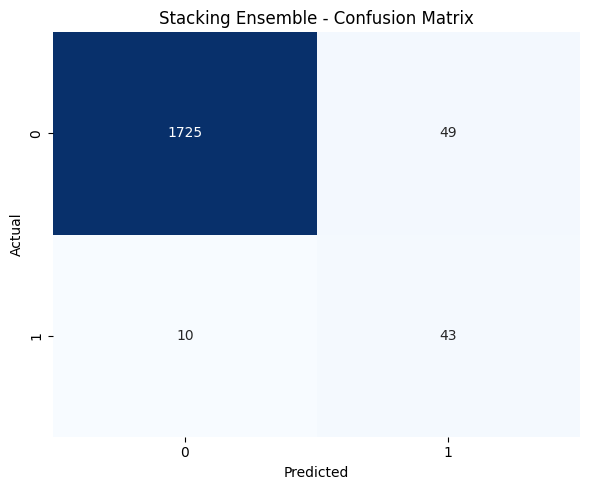

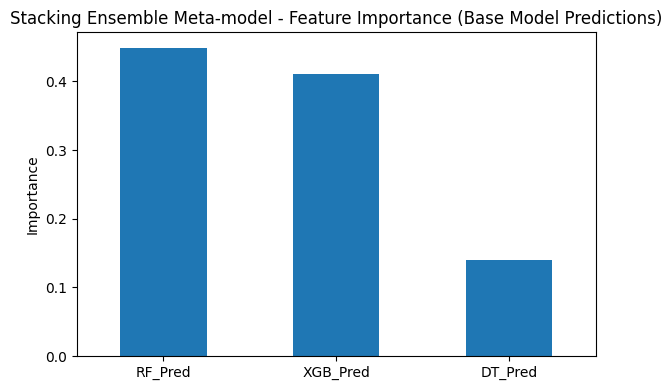

In [ ]:
# prompt: stack  Best Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 2}
# ,Best Random Forest Parameters: {'n_estimators': 466, 'max_depth': 44, 'min_samples_split': 16, 'min_samples_leaf': 2, 'criterion': 'entropy'}
#  and Best XGBoost Parameters: {'eta': 0.08383786318755987, 'max_depth': 8, 'subsample': 0.859701270465782, 'colsample_bytree': 0.9242240119209679, 'min_child_weight': 3, 'gamma': 0.04027764375593427, 'lambda': 1.288708621489399, 'alpha': 1.6320150853524629}
# as base models into a stacking ensemble xgboost ( train xgboost on their predictions,
# )meta model use optuna to find best hyper parameter for thr xgboost


# Get predictions from the base models on the training data
train_pred_dt = dt_model.predict_proba(X_train_bal)[:, 1]
train_pred_rf = rf_model.predict_proba(X_train_bal)[:, 1]
train_pred_xgb = xgb_model.predict_proba(X_train_bal)[:, 1]

# Create the training data for the meta-model (XGBoost)
# We use the out-of-fold predictions if implementing more robust stacking,
# but for simplicity here, we use predictions on the training set.
# A more robust approach would involve k-fold cross-validation to generate
# predictions on unseen data from each base model for the meta-model training.
X_meta_train = np.column_stack((train_pred_dt, train_pred_rf, train_pred_xgb))


# Get predictions from the base models on the test data
test_pred_dt = dt_model.predict_proba(X_test_reduced)[:, 1]
test_pred_rf = rf_model.predict_proba(X_test_reduced)[:, 1]
test_pred_xgb = xgb_model.predict_proba(X_test_reduced)[:, 1]

# Create the test data for the meta-model
X_meta_test = np.column_stack((test_pred_dt, test_pred_rf, test_pred_xgb))


# Define the objective function for optimizing the meta-model (XGBoost)
def objective_meta_xgb(trial):
    param = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "eta": trial.suggest_float("eta", 0.005, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0, 0.5),
        "lambda": trial.suggest_float("lambda", 0.5, 2),
        "alpha": trial.suggest_float("alpha", 0.5, 2),
        "scale_pos_weight": (y_train_bal == 0).sum() / (y_train_bal == 1).sum(), # Use scaled y_train for balance
        "seed": 42
    }
    meta_model = XGBClassifier(**param, use_label_encoder=False)
    meta_model.fit(X_meta_train, y_train_bal) # Train on the meta-training data (base model predictions)
    preds = meta_model.predict(X_meta_test)   # Predict on the meta-test data
    return f1_score(y_test, preds)           # Evaluate using the true y_test

# Run Optuna study for the meta-model
print("\nOptimizing Stacking Meta-model (XGBoost)...")
study_meta_xgb = optuna.create_study(direction="maximize")
study_meta_xgb.optimize(objective_meta_xgb, n_trials=50)

# Train the final stacking meta-model with the best parameters
print("\nBest Stacking Meta-model (XGBoost) Parameters:", study_meta_xgb.best_params)
meta_xgb_params = study_meta_xgb.best_params
meta_xgb_params.update({
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "scale_pos_weight": (y_train_bal == 0).sum() / (y_train_bal == 1).sum()
})
stacked_model = XGBClassifier(**meta_xgb_params, use_label_encoder=False, random_state=42)
stacked_model.fit(X_meta_train, y_train_bal)

# Evaluate the stacked model on the test set
print("\nEvaluating Stacking Ensemble Model (XGBoost Meta-model)...")
y_pred_stacked = stacked_model.predict(X_meta_test)

print("\nStacking Ensemble - Classification Report:")
print(classification_report(y_test, y_pred_stacked, zero_division=0))

cm_stacked = confusion_matrix(y_test, y_pred_stacked)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_stacked, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Stacking Ensemble - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Feature importance for the meta-model (predictions from base models are the features)
if hasattr(stacked_model, 'feature_importances_'):
    importances_stacked = stacked_model.feature_importances_
    meta_feature_names = ['DT_Pred', 'RF_Pred', 'XGB_Pred'] # Names for the meta-features
    pd.Series(importances_stacked, index=meta_feature_names).sort_values(ascending=False).plot(kind='bar', figsize=(6, 4))
    plt.title('Stacking Ensemble Meta-model - Feature Importance (Base Model Predictions)')
    plt.ylabel('Importance')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


[I 2025-06-28 11:41:50,246] A new study created in memory with name: no-name-6a60895a-3da9-4c41-b828-a6190cf45619



Optimizing Voting Classifier weights with Optuna...


[I 2025-06-28 11:42:00,351] Trial 0 finished with value: 0.593103448275862 and parameters: {'w_dt': 0.7065545314831424, 'w_rf': 2.8874082395502865, 'w_xgb': 3.277223600542902}. Best is trial 0 with value: 0.593103448275862.
[I 2025-06-28 11:42:06,261] Trial 1 finished with value: 0.6074074074074074 and parameters: {'w_dt': 3.244508511770901, 'w_rf': 2.379909730322788, 'w_xgb': 2.6258025675272303}. Best is trial 1 with value: 0.6074074074074074.
[I 2025-06-28 11:42:13,565] Trial 2 finished with value: 0.589041095890411 and parameters: {'w_dt': 0.5969181787987856, 'w_rf': 3.7041513696857087, 'w_xgb': 4.797759561807338}. Best is trial 1 with value: 0.6074074074074074.
[I 2025-06-28 11:42:19,670] Trial 3 finished with value: 0.5734265734265734 and parameters: {'w_dt': 0.18202469014480901, 'w_rf': 2.384246537149254, 'w_xgb': 2.166212975188786}. Best is trial 1 with value: 0.6074074074074074.
[I 2025-06-28 11:42:31,694] Trial 4 finished with value: 0.5942028985507246 and parameters: {'w_dt':


Best Voting Classifier Weights: {'w_dt': 4.3280412445809455, 'w_rf': 4.460925271942345, 'w_xgb': 1.6932261136802786}

Training final Voting Classifier with best weights...

Evaluating Final Voting Classifier...

Voting Classifier - Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1774
           1       0.54      0.81      0.65        53

    accuracy                           0.97      1827
   macro avg       0.77      0.90      0.82      1827
weighted avg       0.98      0.97      0.98      1827



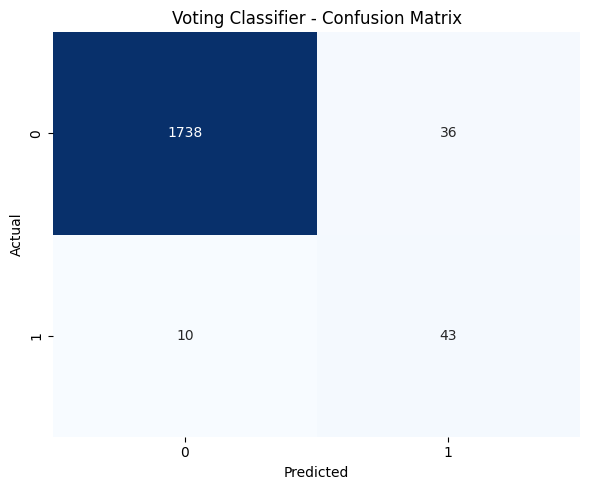

In [ ]:
#  use a voting classifier instead and use opyuna to determine best weight


from sklearn.ensemble import VotingClassifier


# Define the base estimators for the Voting Classifier
estimators = [
    ('dt', DecisionTreeClassifier(**study_dt.best_params, random_state=42)),
    ('rf', RandomForestClassifier(**study_rf.best_params, random_state=42, n_jobs=-1)),
    ('xgb', XGBClassifier(**study_xgb.best_params, use_label_encoder=False, eval_metric='logloss', random_state=42, scale_pos_weight=(y_train_bal == 0).sum() / (y_train_bal == 1).sum()))
]

# Objective function for Optuna to optimize VotingClassifier weights
def objective_voting(trial):
    # Suggest weights for each estimator
    # Weights are constrained to be non-negative and their sum doesn't have to be 1,
    # but normalizing them later might be helpful or Optuna handles it internally.
    # For simplicity, suggesting independent weights and letting the VotingClassifier
    # normalize them or handle them as is. Optuna documentation suggests that
    # weights can be any positive float.
    w_dt = trial.suggest_float("w_dt", 0.1, 5.0)
    w_rf = trial.suggest_float("w_rf", 0.1, 5.0)
    w_xgb = trial.suggest_float("w_xgb", 0.1, 5.0)

    # Create the Voting Classifier with the suggested weights
    # Use 'soft' voting as the base estimators can predict probabilities
    voting_clf = VotingClassifier(
        estimators=estimators,
        voting='soft',
        weights=[w_dt, w_rf, w_xgb],
        n_jobs=-1
    )

    # Train the Voting Classifier
    # Need to use the scaled data for Logistic Regression and SVM if included
    # In this specific case, DT, RF, and XGB do not strictly require scaled data,
    # but for consistency and if including other models, scaling might be needed
    # for all inputs to the VotingClassifier or handle scaling within the estimators
    # if possible. Since the base estimators were trained on X_train_bal, we'll
    # train the voting classifier on X_train_bal as well.
    # If Logistic Regression or SVM were part of the voting, we would need to
    # train them on scaled data. The current best models are DT, RF, XGB,
    # which don't strictly need scaling beyond what might have been done for initial tuning.
    # Given the previous code, X_train_bal is the data after SMOTE, but before standard scaling.
    # The base models (DT, RF, XGB) as defined here are trained on X_train_bal.
    # We will continue to train the voting classifier on X_train_bal.
    # Prediction on X_test_reduced.
    voting_clf.fit(X_train_bal, y_train_bal)

    # Make predictions on the test set
    preds = voting_clf.predict(X_test_reduced)

    # Return the F1 score as the objective value to maximize
    return f1_score(y_test, preds)

# Run Optuna study for the Voting Classifier weights
print("\nOptimizing Voting Classifier weights with Optuna...")
study_voting = optuna.create_study(direction="maximize")
study_voting.optimize(objective_voting, n_trials=100) # Adjust n_trials as needed

# Get the best weights and train the final Voting Classifier
print("\nBest Voting Classifier Weights:", study_voting.best_params)
best_weights = [study_voting.best_params["w_dt"], study_voting.best_params["w_rf"], study_voting.best_params["w_xgb"]]

final_voting_clf = VotingClassifier(
    estimators=estimators,
    voting='soft',
    weights=best_weights,
    n_jobs=-1
)

print("\nTraining final Voting Classifier with best weights...")
final_voting_clf.fit(X_train_bal, y_train_bal)

# Evaluate the final Voting Classifier
print("\nEvaluating Final Voting Classifier...")
y_pred_voting = final_voting_clf.predict(X_test_reduced)

print("\nVoting Classifier - Classification Report:")
print(classification_report(y_test, y_pred_voting, zero_division=0))

cm_voting = confusion_matrix(y_test, y_pred_voting)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_voting, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Voting Classifier - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

